## Задача проекта: провести оценку результатов A/B-теста

- Для оценки корректности проведения теста проверить:
    - пересечение тестовой аудитории с конкурирующим тестом;
    - совпадение теста и маркетинговых событий, другие проблемы временных границ теста.
    
- Проанализировать результаты теста.

### Техническое задание
Название теста: recommender_system_test;

Группы: А (контрольная), B (новая платёжная воронка);

Дата запуска: 2020-12-07;

Дата остановки набора новых пользователей: 2020-12-21;

Дата остановки: 2021-01-04;

Аудитория: 15% новых пользователей из региона EU;

Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;

Ожидаемое количество участников теста: 6000.

Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 
10%:
- конверсии в просмотр карточек товаров — событие product_page
- просмотры корзины — product_cart
- покупки — purchase.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from scipy import stats as st

plt.style.use('seaborn-whitegrid')
# %config InlineBackend.figure_format = 'retina'
%config InlineBackend.figure_formats = ['svg']

## Описание данных

`/datasets/ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год;

Структура файла:

* name — название маркетингового события;
* regions — регионы, в которых будет проводиться рекламная кампания;
* start_dt — дата начала кампании;
* finish_dt — дата завершения кампании.
    
`/datasets/final_ab_new_users.csv` — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года;

Структура файла:

* user_id — идентификатор пользователя;
* first_date — дата регистрации;
* region — регион пользователя;
* device — устройство, с которого происходила регистрация.

`/datasets/final_ab_events.csv` — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;

Структура файла:

* user_id — идентификатор пользователя;
* event_dt — дата и время события;
* event_name — тип события;
* details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

`/datasets/final_ab_participants.csv` — таблица участников тестов.

Структура файла:

* user_id — идентификатор пользователя;
* ab_test — название теста;
* group — группа пользователя.

## Предобработка данных

### Загрузка и предварительное ознакомление

#### Маркетинговые события 
- 13 записей, выведем полностью

In [2]:
marketing = pd.read_csv('/datasets/ab_project_marketing_events.csv').sort_values(by='start_dt')
marketing

,name,regions,start_dt,finish_dt
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
4,4th of July Promo,N.America,2020-07-04,2020-07-11
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


#### Новые пользователи

In [3]:
newb = pd.read_csv('/datasets/final_ab_new_users.csv')

- Пропусков нет, названия нормальные
- 62 тысячи уникальных пользователей
- Даты приведем к формату дата

In [4]:
newb['first_date'] = pd.to_datetime(newb['first_date'])

In [5]:
print ('дубликатов: ', newb.duplicated().sum())
print ('дубликатов user_id: ', newb['user_id'].duplicated().sum())
print ()
newb.info()
newb.head(3)

дубликатов:  0
дубликатов user_id:  0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC


Похоже на **недельные циклы регистрации**. Пик в понедельник, провал в среду.

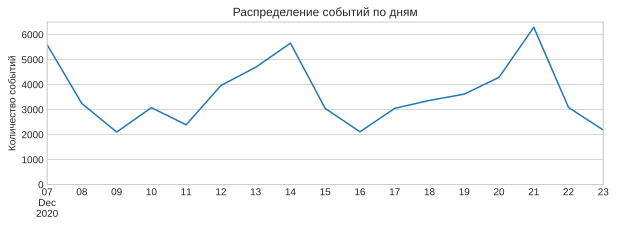

In [6]:
fig, ax = plt.subplots(figsize=(10,3))
newb['first_date'].value_counts().sort_index().plot()
ax.set_ylim(ymin=0)
ax.set_ylabel('Количество событий')
plt.title ('Распределение событий по дням');

<div class="alert alert-block alert-info">
✅
    
</div>

4 региона, 4 устройства

In [7]:
def plot1 (feature, count_by, title):

    l = newb.pivot_table(index='first_date', columns=feature, values=count_by, aggfunc='count')
    p = newb[feature].value_counts()

    fig, axs = plt.subplots(1, 2, figsize=(12,3), gridspec_kw={'width_ratios': [1,4]})
    axs[1].plot(l)
    axs[1].set_ylim(ymin=0)
    axs[1].grid(visible=True)
    axs[1].legend(l.columns).set_visible(True)
    axs[0].pie(p, labels=p.index,
                  startangle = 90, counterclock = False, autopct="%.1f%%"
              )
    plt.suptitle(title, fontsize=14);

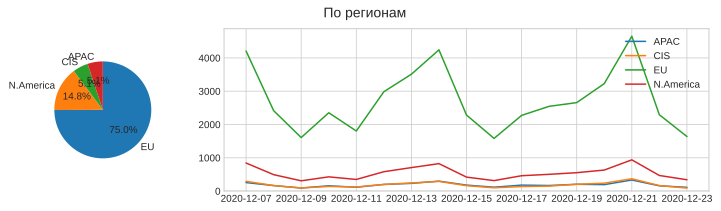

In [8]:
plot1('region', 'device', 'По регионам')

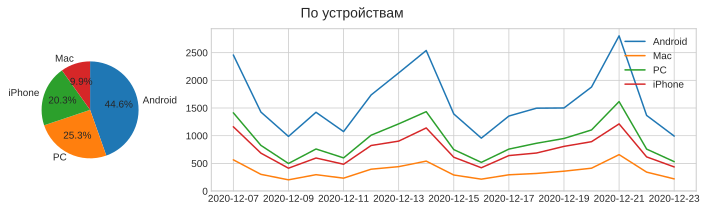

In [9]:
plot1('device', 'region', 'По устройствам')

#### Новые пользователи - события

In [10]:
event = pd.read_csv('/datasets/final_ab_events.csv')

- 440 тыс. событий
- названия ок
- event_dt нужно привести к datetime
- количество записей в details совпадает с количеством событий purchase и содержит стоимость покупки в долларах

In [11]:
event['event_dt'] = pd.to_datetime(event['event_dt'])
event['event_d'] = event['event_dt'].dt.date

In [12]:
print ('дубликатов: ', event.duplicated().sum())
print ()

event.info()
event.sample(5)

дубликатов:  0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
 4   event_d     440317 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 16.8+ MB


,user_id,event_dt,event_name,details,event_d
190544,82C72B5DE104A508,2020-12-19 07:57:54,product_page,NaN,2020-12-19
213474,C35596C2EF5C15E4,2020-12-22 18:25:11,product_page,NaN,2020-12-22
227511,8A105997C2702C55,2020-12-24 20:30:02,product_page,NaN,2020-12-24
429511,66F0B99E4610F083,2020-12-27 03:44:30,login,NaN,2020-12-27
43806,B5655875072540B0,2020-12-22 08:12:10,purchase,4.99,2020-12-22


In [13]:
print('Количество событий')
display(event['event_name'].value_counts())
print('-----------------------------------------------')
print('Количество деталей, сгруппированное по событиям')
event.groupby('event_name')['details'].count()

Количество событий


login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

-----------------------------------------------
Количество деталей, сгруппированное по событиям


event_name
login               0
product_cart        0
product_page        0
purchase        62740
Name: details, dtype: int64

In [14]:
def histbox(d):  #series для визуализации
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(10,3))
    sns.boxplot(x=d, ax=ax_box)
    sns.histplot(x=d, ax=ax_hist)
    ax_box.set(xlabel='');

Количество событий на пользователя - выбросов немного

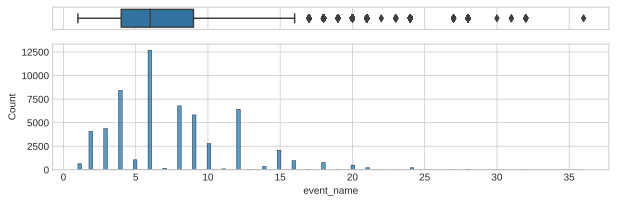

In [15]:
histbox (event.groupby('user_id')['event_name'].count())


**сумма покупок на человека - есть существенные выбросы**

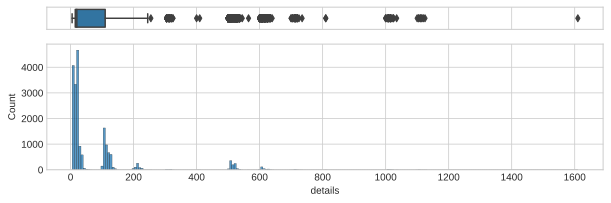

In [16]:
histbox (event.query('event_name == "purchase"').groupby('user_id')['details'].sum())


По количеству покупок на человека выбросы приемлемые

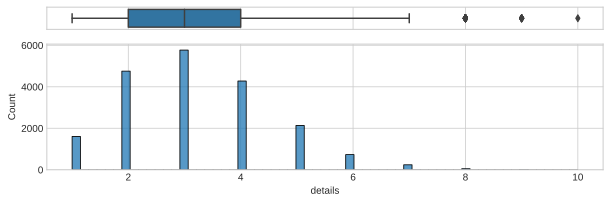

In [17]:
histbox (event.query('event_name == "purchase"').groupby('user_id')['details'].count())

Отдельные покупки - есть всего четыре цены

In [18]:
event.query('event_name == "purchase"')['details'].value_counts()

4.99      46362
9.99       9530
99.99      5631
499.99     1217
Name: details, dtype: int64

#### Участники А/В тестов

In [19]:
ab = pd.read_csv('/datasets/final_ab_participants.csv')

В наборе есть данные об участниках тестов 'recommender_system_test', 'interface_eu_test'. 
Мы анализируем только 'recommender_system_test'

In [20]:
ab['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

In [21]:
ab.info()
display (ab.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test


In [22]:
ab.pivot_table(index='ab_test', columns='group', values='user_id', aggfunc='count', margins=True)

group,A,B,All
ab_test,,,
interface_eu_test,5831,5736,11567
recommender_system_test,3824,2877,6701
All,9655,8613,18268


**<font color='red'> в файле с событиями нет событий для 3+ тысяч пользователей из списка участников АБ теста </font>**

In [23]:
no_action = ab.merge(event, on='user_id', how='left')

In [24]:
display (no_action.query('event_name.isna()').sample(3))
print ('Нет действий в файле с действиями для {} пользователей'.format(no_action.query('event_name.isna()')['user_id'].nunique()))

,user_id,group,ab_test,event_dt,event_name,details,event_d
19384,56D37845DD2DDC2D,B,recommender_system_test,NaT,NaN,NaN,NaN
9847,5FF22657AE9EC2D6,A,recommender_system_test,NaT,NaN,NaN,NaN
27611,B14FCACE3018056B,B,recommender_system_test,NaT,NaN,NaN,NaN


Нет действий в файле с действиями для 3028 пользователей


### **profile**: cоздадим профили участников А/В теста

- дубликатов user_id и типа теста нет => каждый пользователь находится только в одной группе каждого теста
- однако есть дубликаты user_id => значит пользователи пересекаются по тестам

In [25]:
print ('дубликатов user_id и типа теста:', ab[['user_id', 'ab_test']].duplicated().sum())
print ('дубликатов user_id:', ab['user_id'].duplicated().sum())

дубликатов user_id и типа теста: 0
дубликатов user_id: 1602


1602 пользователя приняли участие в обоих тестах. Это практически четверть участников нашего теста. Они равномерно распределены по группам А и Б.

In [26]:
print ('доля пользователей, участвовавших в обоих тестах')

display (
    # количество дубликатов в каждой группе
    ab.query('user_id.duplicated(keep=False)')
    .pivot_table(index='ab_test', columns='group', values='user_id', aggfunc='count', margins=True)
    # общее количество участников теста в каждой группе
    /ab.pivot_table(index='ab_test', columns='group', values='user_id', aggfunc='count', margins=True)
)

доля пользователей, участвовавших в обоих тестах


group,A,B,All
ab_test,,,
interface_eu_test,0.140456,0.136506,0.138497
recommender_system_test,0.240847,0.236705,0.239069
All,0.180218,0.169976,0.175389


#### - выберем только участников теста recommender_system_test  
#### - отбросим дубликаты (участников двух тестов, которые входили в тестовую группу)
#### - набор новых пользователей остановлен после 21 декабря, так что есть  достаточное время на финализацию конверсии

In [27]:
profile = newb.merge(
    # выберем только участников теста recommender_system_test и отбросим дубликаты
    ab.query('ab_test == "recommender_system_test" and not (user_id.duplicated(keep=False) and group == "B")')[['user_id', 'group']],
    how='inner' # отбросим остальные записи
    )

Количество участников recommender_system_test в списке участников А/В теста минус количество дубликатов совпадает с количеством полученных профилей

In [28]:
display (ab
         .query('not user_id.duplicated(keep=False)')
         .pivot_table(index='ab_test', columns='group', values='user_id', aggfunc='count', margins=True))
print ("получено профилей: ", profile.shape[0])
profile.shape

group,A,B,All
ab_test,,,
interface_eu_test,5012,4953,9965
recommender_system_test,2903,2196,5099
All,7915,7149,15064


получено профилей:  6020


(6020, 5)

#### - отбросим регионы кроме EU
так как в ТЗ указано 15% новых пользователей **из региона EU**
<br> таких пользователей 93% в наборе данных

In [29]:
profile['region'].value_counts(normalize=True)

EU           0.941860
N.America    0.037043
APAC         0.011960
CIS          0.009136
Name: region, dtype: float64

In [30]:
print('доля участников АБ теста среди всех новых пользователей из региона EU')
profile.query('region == "EU"').shape[0] / newb.query('region == "EU"').shape[0]

доля участников АБ теста среди всех новых пользователей из региона EU


0.12254160363086233

Оставим только профили участников теста из EU и удалим колонку "регион"

In [31]:
profile = profile.query('region == "EU"').drop(columns=['region'])
print (profile.shape)
profile.sample()

(5670, 4)


,user_id,first_date,device,group
3331,A53AD293529FC05E,2020-12-17,PC,A


#### - отбросим профили, для которых нет действий

In [32]:
active = event['user_id'].unique()
profile = profile.query('user_id in @active')

In [33]:
profile.shape

(3259, 4)

### **event_ab**: cоздадим набор данных с действиями, относящимися к АБ тесту.
- объединим профили участников АБ теста с событиями
- добавим лайфтаймы событий
- <mark> отбросим лайфтаймы меньше 14 </mark>

In [34]:
event_ab=(
    profile
    #объединим inner join, тем самым отбросим профили, для которых нет событий
    .merge(event, on='user_id', how='left')
    .assign(lt = lambda x: (x['event_dt'] -  x['first_date']).astype("timedelta64[D]"))
         ).query('lt < 14')
event_ab.sample(3)

,user_id,first_date,device,group,event_dt,event_name,details,event_d,lt
15558,AC14EB0BD5437B7D,2020-12-11,Android,A,2020-12-11 15:23:32,login,NaN,2020-12-11,0.0
11632,7AF743F4C4544763,2020-12-16,Mac,A,2020-12-16 06:25:26,product_cart,NaN,2020-12-16,0.0
3432,8856383B9441DF73,2020-12-14,Android,A,2020-12-16 01:22:10,product_page,NaN,2020-12-16,2.0


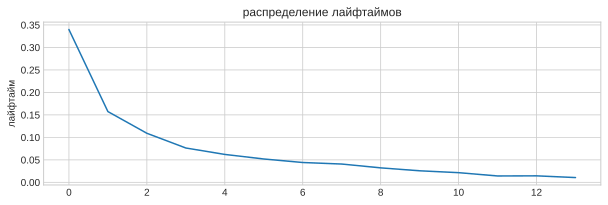

In [35]:
fig,ax = plt.subplots(figsize=(10,3))
event_ab['lt'].value_counts(normalize=True).sort_index().plot(title='распределение лайфтаймов')
ax.set_ylabel('% лайфтаймов от общего числа')
ax.set_ylabel('лайфтайм');

In [36]:
print ('В наборе данных осталось уникальных профилей: ', event_ab['user_id'].nunique())
print ('действий, относящихся к АБ тесту: ', event_ab.shape[0])

В наборе данных осталось уникальных профилей:  3259
действий, относящихся к АБ тесту:  21379


### Выводы

Исходный набор данных:

* 440 тыс. событий
* качество данных ок
* количество записей в details совпадает с количеством событий purchase и содержит стоимость покупки в долларах
* выбросов в количестве событий нет, распределение похоже на нормальное
* выбросы в сумме покупок есть, но они объясняются структурой цены: в наборе всего 4 варианта цены, максимальная отличается от остальных на 1 - 2 порядка (500, 100, 50, 5 долл.)
* В наборе данных 4 региона, 4 устройства.
* Похоже что в количестве регистраций есть недельные циклы. Пик в понедельник, провал в среду.

УЧАСТНИКИ АБ ТЕСТА:
* **в файле с событиями нет событий для 3+ тысяч пользователей из списка участников АБ теста**
* 1602 пользователя приняли участие в обоих тестах. Это практически четверть участников нашего теста. Они равномерно распределены по группам А и Б.
* только 93% участников АБ теста относятся к региону EU
---
**После очистки данных от погрешностей, описанных выше в наборе данных по АБ тесту осталось только 3259 профилей**

## Исследовательский анализ данных

###  Корректность проведения теста

In [37]:
d_min = event_ab['event_dt'].min()
d_max = event_ab['event_dt'].max()
print ("Начало и конец данных")
print (d_min)
print (d_max)

Начало и конец данных
2020-12-07 00:14:01
2020-12-29 23:38:29


In [38]:
print('событие, пересекающееся с АБ тестом')
marketing.loc[[0]]

событие, пересекающееся с АБ тестом


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


In [39]:
print('доля участников АБ теста среди всех новых пользователей из региона EU')
profile.shape[0] / newb.query('region == "EU"').shape[0]

доля участников АБ теста среди всех новых пользователей из региона EU


0.07043440674303005

#### Есть существенные отклонения от ТЗ

✅ Название теста: recommender_system_test;

✅ Группы: А (контрольная), B (новая платёжная воронка);

✅ Дата запуска: 2020-12-07;

✅ Дата остановки набора новых пользователей: 2020-12-21;

🔶 Дата остановки: 2021-01-04: 
* <mark>данные заканчиваются 2020-12-30</mark>

❌ Аудитория: 15% новых пользователей из региона EU:
* <mark>после очистки профилей от дубликатов, других регионов, записей для которых нет действий доля участников АБ теста составит только 5% от новых пользователей</mark>

✅ Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;

❌ Ожидаемое количество участников теста: 6000

* <mark>количество уникальных профилей после очистки данных: 2594</mark> 

#### Время проведения теста частично совпадает с рождественским промо

🔶  <mark>Рождественское промо начинается 25 декабря, тест заканчивается 4 января, данные заканчиваются 30 декабря</mark>

#### Вывод: 
* Пользователей, пригодных к анализу по АБ тесту в 2 раза меньше, чем требуется в соответствии с ТЗ
* Тест пересекается по времени с рождественским промо. Его можно будет признать состоявшимся только если кумулятивные метрики стабилизируются раньше 25 декабря

### Распределение событий в выборках

- количество событий в общем наборе и в выборке в целом выглядит логично
- количество событий в разных категориях (от логина до покупки) растет и падает в один день, без задержки по времени. Можем предположить, что решения о покупке принимаются быстро и можно не закладывать в расчеты время на принятие решения;
- кол-во событий product_cart практически совпадает с purchase, что еще раз подтверждает, что на решение о покупке не требуется существенного времени;
- данные группы А заканчиваются 29 декабря, а группы Б - 30 декабря. Для нас это не критично, т.к. данные после 25 декабря в любом случае будут искажены рождественским промо

In [40]:
event_ab.pivot_table(index='event_d', columns='group', values='event_name', aggfunc='count')

group,A,B
event_d,,
2020-12-07,318,268
2020-12-08,313,169
2020-12-09,371,250
2020-12-10,331,182
2020-12-11,356,115
2020-12-12,346,150
2020-12-13,308,103
2020-12-14,1015,193
2020-12-15,1030,164


''

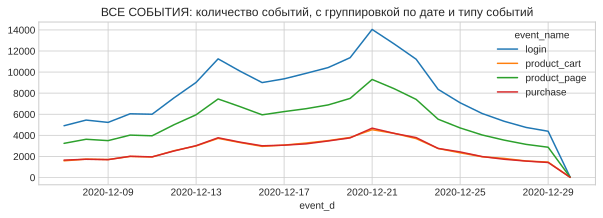

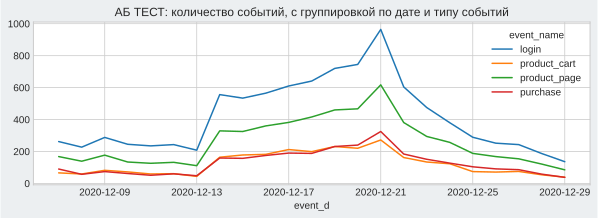

In [41]:
fig, ax = plt.subplots(figsize=(10,3))
event.pivot_table(index='event_d', columns='event_name', values='user_id', aggfunc='count').plot(ax=ax)
# ax.set_ylim(0, 5000)
plt.title('ВСЕ СОБЫТИЯ: количество событий, с группировкой по дате и типу событий')
;

fig, ax = plt.subplots(figsize=(10,3))
fig.patch.set_facecolor('#ECEFF1')
event_ab.pivot_table(index='event_d', columns='event_name', values='user_id', aggfunc='count').plot(ax=ax)
plt.title('АБ ТЕСТ: количество событий, с группировкой по дате и типу событий')
;

Количество событий на пользователя - выбросы приемлемые

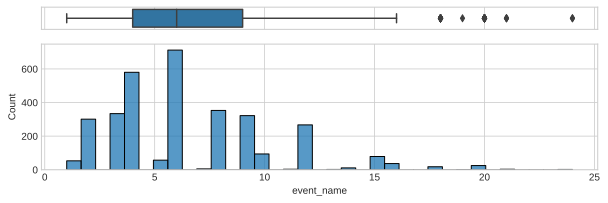

In [42]:
histbox (event_ab.groupby('user_id')['event_name'].count())


**сумма покупок на человека - есть существенные выбросы**
<br>как уже видели раньше - это скорее всего связано с тем, что отдельные покупки на 1 - 2 порядка дороже основной массы покупок. Так как нас интересует только конверсия, а не средний чек, считаю, что ничего с этим делать не нужно.

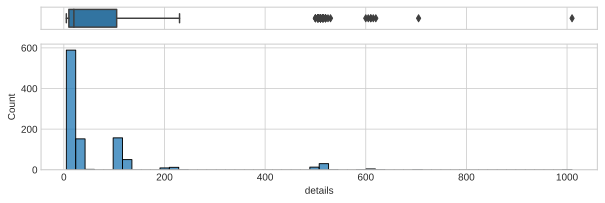

In [43]:
histbox (event_ab.query('event_name == "purchase"').groupby('user_id')['details'].sum())


По количеству покупок на человека выбросов нет.

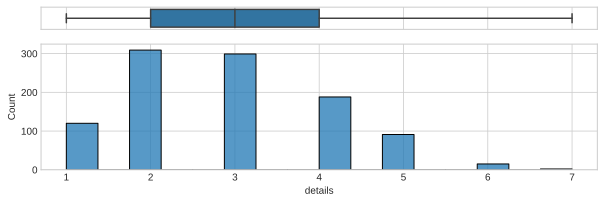

In [44]:
histbox (event_ab.query('event_name == "purchase"').groupby('user_id')['details'].count())

### Количество покупок с разбивкой по цене

В наборе данных всего 4 возможных цены покупки, причем максимальная отличается от минимальной в 100 раз

**Было бы интересно отдельно проанализировать последовательность действий при совершении дорогих покупок**

Однако в данном случае таких покупок порядка 2% от общего количества и их динамикой можно пренебречь

In [45]:
event.query('event_name == "purchase"')['details'].value_counts()

4.99      46362
9.99       9530
99.99      5631
499.99     1217
Name: details, dtype: int64

In [46]:
d = (
    event.query('event_name == "purchase"')
    .pivot_table(index='user_id', columns='details', values='event_name', aggfunc='count')
    )
e = (
    event_ab.query('event_name == "purchase"')
    .pivot_table(index='user_id', columns='details', values='event_name', aggfunc='count')
    )

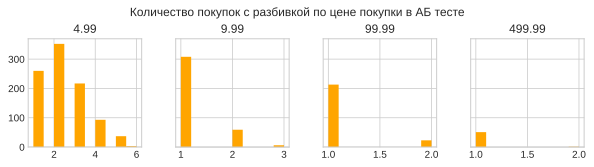

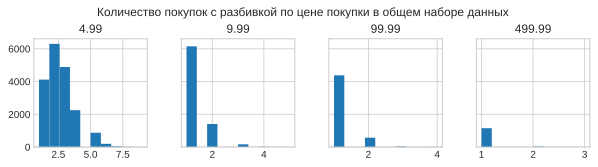

In [47]:
e.hist(figsize = (10,2), layout=(1,4), color='orange', sharey=True)
plt.suptitle('Количество покупок с разбивкой по цене покупки в АБ тесте', y = 1.1);
d.hist(figsize = (10,2), layout=(1,4), sharey=True)
plt.suptitle('Количество покупок с разбивкой по цене покупки в общем наборе данных', y = 1.1);

''

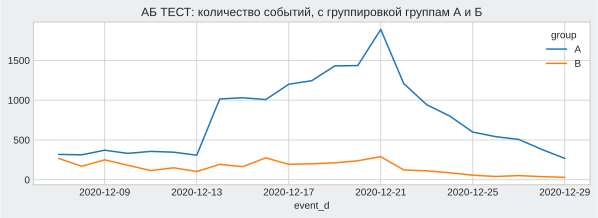

In [48]:
fig, ax = plt.subplots(figsize=(10,3))
fig.patch.set_facecolor('#ECEFF1')
event_ab.pivot_table(index='event_d', columns='group', values='user_id', aggfunc='count').plot(ax=ax)
plt.title('АБ ТЕСТ: количество событий, с группировкой группам А и Б')
;

    
<mark>события неравномерно распределены по группам А и Б (в группе А есть существенный пик около 21 декабря, в группе Б его нет)</mark>

## Анализ результатов АБ теста

### Посчитаем кумулятивно события по группам

In [49]:
# Разберем набор event_ab на события
df1 = event_ab.pivot_table(
    index=['event_d', 'group', 'user_id'], columns='event_name', values='device', aggfunc='count'
).reset_index().fillna(0)
df1.tail(5)

event_name,event_d,group,user_id,login,product_cart,product_page,purchase
9611,2020-12-29,B,9036DBDE7AF034E8,1.0,1.0,1.0,1.0
9612,2020-12-29,B,A5D8C583CD59B97A,1.0,0.0,1.0,0.0
9613,2020-12-29,B,B2A29A177F435D9E,1.0,0.0,0.0,1.0
9614,2020-12-29,B,F37346E94569EA9E,1.0,0.0,0.0,0.0
9615,2020-12-29,B,FDF5D9D1B047FA31,1.0,1.0,0.0,0.0


In [50]:
# создаем массив уникальных пар значений дат и групп теста
date_group = event_ab[['event_d','group']].drop_duplicates().sort_values(by='event_d') 
date_group.head()

,event_d,group
0,2020-12-07,A
10,2020-12-07,B
5,2020-12-08,A
11,2020-12-08,B
3,2020-12-09,A


In [51]:
# получаем агрегированные кумулятивные по дням данные о действиях 
df2 = (
    date_group
    .apply(lambda x: 
           df1[
               np.logical_and(
                   df1['event_d'] <= x['event_d'], 
                   df1['group'] == x['group'])]
           .agg(
               {'event_d' : 'max', 
                'group' : 'max', 
                'user_id' : 'nunique',  # считаем уникальных посетителей
                'product_cart':'sum', # считаем количество событий
                'product_page':'sum', 
                'purchase':'sum'
               }), axis=1
          )
    
)
df2.columns = df2.columns.str.replace('product_', '')
df2.tail(3)

,event_d,group,user_id,cart,page,purchase
5491,2020-12-28,B,655,470.0,901.0,457.0
5207,2020-12-29,A,2604,2361.0,5082.0,2485.0
5492,2020-12-29,B,655,472.0,909.0,461.0


In [52]:
# вынесем группу в колонки
event_agg = df2.pivot_table(
        index='event_d', columns='group', values =['user_id', 'cart','page', 'purchase'], aggfunc='sum'
    )
event_agg.columns=['_'.join(col).strip() for col in event_agg.columns.values]
event_agg

,cart_A,cart_B,page_A,page_B,purchase_A,purchase_B,user_id_A,user_id_B
event_d,,,,,,,,
2020-12-07,35.0,31.0,92.0,76.0,43.0,47.0,148,119
2020-12-08,71.0,54.0,190.0,117.0,76.0,71.0,240,152
2020-12-09,121.0,86.0,293.0,191.0,123.0,98.0,322,208
2020-12-10,166.0,113.0,381.0,237.0,165.0,118.0,383,236
2020-12-11,210.0,128.0,477.0,267.0,205.0,129.0,471,249
2020-12-12,257.0,142.0,570.0,306.0,243.0,151.0,533,287
2020-12-13,291.0,152.0,658.0,329.0,275.0,167.0,585,299
2020-12-14,427.0,180.0,943.0,373.0,408.0,193.0,951,354
2020-12-15,582.0,203.0,1229.0,412.0,545.0,213.0,1153,377


Посчитаем конверсии

In [53]:
event_agg.columns

Index(['cart_A', 'cart_B', 'page_A', 'page_B', 'purchase_A', 'purchase_B',
       'user_id_A', 'user_id_B'],
      dtype='object')

In [54]:
conv = event_agg[['cart_A', 'page_A', 'purchase_A']].divide(event_agg['user_id_A'], axis='rows')
conv[['cart_B', 'page_B', 'purchase_B']] = event_agg[['cart_B', 'page_B', 'purchase_B']].divide(event_agg['user_id_B'], axis='rows')
conv

,cart_A,page_A,purchase_A,cart_B,page_B,purchase_B
event_d,,,,,,
2020-12-07,0.236486,0.621622,0.290541,0.260504,0.638655,0.394958
2020-12-08,0.295833,0.791667,0.316667,0.355263,0.769737,0.467105
2020-12-09,0.375776,0.909938,0.381988,0.413462,0.918269,0.471154
2020-12-10,0.433420,0.994778,0.430809,0.478814,1.004237,0.500000
2020-12-11,0.445860,1.012739,0.435244,0.514056,1.072289,0.518072
2020-12-12,0.482176,1.069418,0.455910,0.494774,1.066202,0.526132
2020-12-13,0.497436,1.124786,0.470085,0.508361,1.100334,0.558528
2020-12-14,0.449001,0.991588,0.429022,0.508475,1.053672,0.545198
2020-12-15,0.504770,1.065915,0.472680,0.538462,1.092838,0.564987


### Построим график кумулятивной конверсии по группам

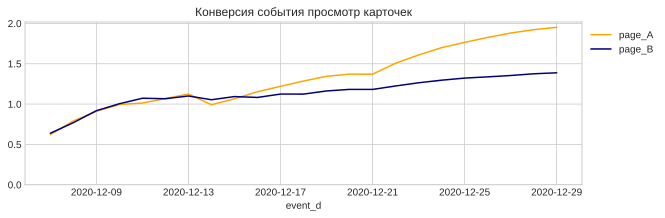

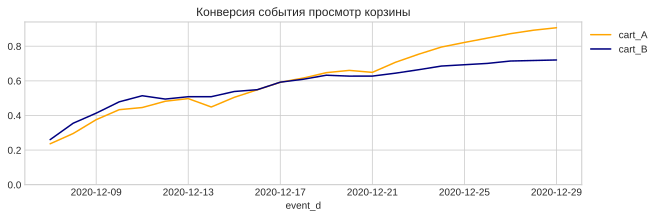

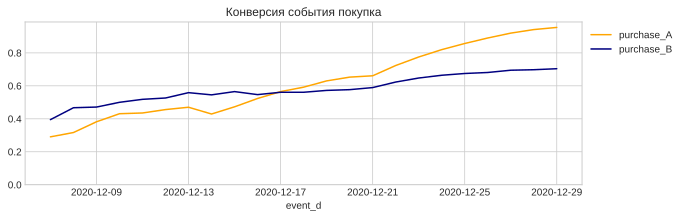

In [55]:
pairs= {"просмотр карточек":['page_A','page_B'], "просмотр корзины":['cart_A','cart_B'], "покупка":['purchase_A', 'purchase_B']}

for key, value  in pairs.items():
    fig, ax = plt.subplots(figsize=(10,3))
    conv[value].plot(ax=ax, cmap = colors.ListedColormap(['orange', 'navy']))
    ax.set_ylim(ymin=0)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title('Конверсия события ' + key)
    ;

Вывод: результат группы Б хуже контрольной группы по всем трем параметрам

### Построим график относительного изменения кумулятивной конверсии группы Б к группе A.

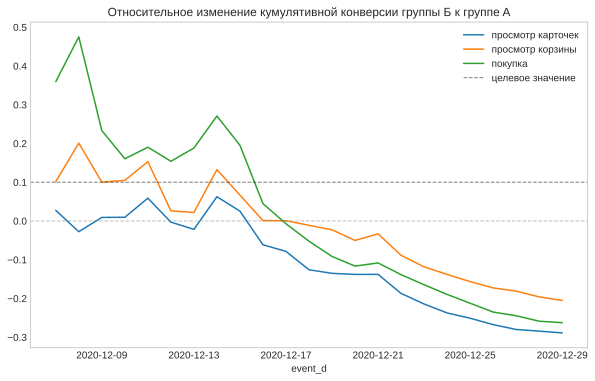

In [56]:
pairs= {"просмотр карточек":['page_A','page_B'], "просмотр корзины":['cart_A','cart_B'], "покупка":['purchase_A', 'purchase_B']}

fig, ax = plt.subplots(figsize=(10,6))
for key, value  in pairs.items():
    (conv[value[1]]/conv[value[0]]-1).plot(ax=ax, label = key)  
plt.axhline(y=0, color='grey', alpha=0.5, linestyle='--', linewidth=1)
plt.axhline(y=0.1, color='black', alpha=0.5, linestyle='--', linewidth=1, label='целевое значение')
plt.grid(visible=False)
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Относительное изменение кумулятивной конверсии группы Б к группе A');

ВЫВОД: Группа Б показала стабильно худший результат по всем трем параметрам.

## Проверим, является ли различие между группами статистически достоверным

Попробовала проверить на нормальность, но потом почитала горячие дебаты про бессмысленность формальной проверки наборов данных больше 5000 записей и убрала

Н0: конверсия для групп А и Б не отличается

Н1: конверсия группы Б ниже конверсии группы А

Для проверки используем z-критерий по долям

In [59]:
sample = event_ab.pivot_table(
    index=('user_id', 'group'), columns='event_name', values='event_dt', aggfunc='count').fillna(0)
sample.sample(3)

,event_name,login,product_cart,product_page,purchase
user_id,group,,,,
F04B8BB68DE7D207,B,1.0,0.0,1.0,0.0
20C1463FD5206164,A,3.0,3.0,0.0,3.0
9C2240EEE1D4AB2D,B,2.0,0.0,2.0,0.0


In [60]:
from statsmodels.stats.weightstats import ztest as ztest
alpha = 0.05

for i in ['product_page', 'product_cart', 'purchase']:

    sample_1 = sample.query('group == "A"')[i]
    sample_2 = sample.query('group == "B"')[i]

    tstat, pval = ztest(sample_1, sample_2, 0)
    print()
    print('\033[1m' + 'событие: ', i.upper(), '\033[0m')
    print('среднее количество событий в группе A', sample_1.mean() )
    print('среднее количество событий в группе Б', sample_2.mean() )
    print('Нулевая гипотеза: средняя конверсия для двух групп не отличается')
    print('Альтернативная гипотеза: средняя конверсия отличается')
    print('Alpha = ', alpha)

    print('p-значение: ', pval)

    if pval < alpha:
        print('\033[1m' + "✅ Отвергаем нулевую гипотезу, средняя конверсия статистически достоверно отличается", '\033[0m')
    else:
        print("❌ Не получилось отвергнуть нулевую гипотезу")  
    print('-----------------------------------')  


событие:  PRODUCT_PAGE 
среднее количество событий в группе A 1.9516129032258065
среднее количество событий в группе Б 1.3877862595419848
Нулевая гипотеза: средняя конверсия для двух групп не отличается
Альтернативная гипотеза: средняя конверсия отличается
Alpha =  0.05
p-значение:  3.1891908373329926e-14
✅ Отвергаем нулевую гипотезу, средняя конверсия статистически достоверно отличается 
-----------------------------------

событие:  PRODUCT_CART 
среднее количество событий в группе A 0.9066820276497696
среднее количество событий в группе Б 0.7206106870229008
Нулевая гипотеза: средняя конверсия для двух групп не отличается
Альтернативная гипотеза: средняя конверсия отличается
Alpha =  0.05
p-значение:  0.004149795823076137
✅ Отвергаем нулевую гипотезу, средняя конверсия статистически достоверно отличается 
-----------------------------------

событие:  PURCHASE 
среднее количество событий в группе A 0.9543010752688172
среднее количество событий в группе Б 0.7038167938931298
Нулевая г

## Выводы

---
#### Качество и особенности общих данных:

* качество данных по всем посетителям - в целом ок, без пробелов, странных искажений.
* количество записей в details совпадает с количеством событий purchase и содержит стоимость покупки в долларах
* выбросов в количестве событий нет, распределение похоже на нормальное
* выбросы в сумме покупок есть, но они объясняются структурой цены: в наборе всего 4 варианта цены, максимальная отличается от остальных на 1 - 2 порядка (500, 100, 50, 5 долл.)
* В наборе данных 4 региона, 4 устройства.
* Похоже что в количестве регистраций есть недельные циклы. Пик в понедельник, провал в среду.
    - количество событий в разных категориях (от логина до покупки) растет и падает в один день, без задержки по времени. Можем предположить, что решения о покупке принимаются быстро и можно не закладывать в расчеты время на принятие решения;
    - кол-во событий product_cart практически совпадает с purchase, что еще раз подтверждает, что на решение о покупке не требуется существенного времени;

---
#### Организация сбора данных и проведения АБ теста:
К сожалению, есть существенные отклонения от заявленных параметров АБ теста:
* 1602 пользователя приняли участие в двух тесах одновременно. Это практически четверть участников нашего теста. Они равномерно распределены по группам А и Б.
* только 93% участников АБ теста относятся к региону EU
* **в файле с событиями нет событий для 3+ тысяч пользователей из списка участников АБ теста**
* Тест пересекся по времени с рождественским промо, которое началось 25 декабря.
* события неравномерно распределены по группам А и Б (в группе А есть существенный пик  около 21 декабря, в группе Б его нет) 

---
#### Соответствие данных по АБ тесту техзаданию:
* После очистки данных от погрешностей, описанных выше, в наборе данных по АБ тесту осталось только 2594 профиля. Это в 2 раза меньше, чем требуется по ТЗ.

---
#### Особенности данных АБ теста:

* Как и ождалось, есть выбросы по сумме покупок. 
    - В наборе данных всего 4 возможных цены покупки, причем максимальная отличается от минимальной в 100 раз
    - Было бы интересно отдельно проанализировать последовательность действий при совершении дорогих покупок
    - Однако в данном случае таких покупок порядка 2% от общего количества и их динамикой можно пренебречь при анализе конверсии

* Нет выбросов по количеству покупок.

---
#### Результаты АБ теста:

**очищенный набор данных существенно отличается от техзадания**:
- если ориентироваться только на имеющиеся данные то группа Б показала результат хуже (по сравнению с тестовой группой);
- однако этот результат нельзя считать достоверным, так как
    - в данных нет событий для 3+ тысяч пользователей из списка участников АБ теста
    - события неравномерно распределены по группам А и Б (в группе А есть существенный пик  около 21 декабря, в группе Б его нет)

###  Вывод: результаты АБ теста нельзя считать достоверными 

РЕКОМЕНДАЦИЯ:

- проверить выгрузку данных (возможно, часть записей утратилась при выгрузке)
- если утраченные записи восстановятся - проанализировать набор данных заново
- если записей нет - провести тест заново